In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

In [42]:
train_file = './data/train.csv'
test_file = './data/test.csv'
trainDF = pd.read_csv(train_file)
testDF = pd.read_csv(test_file)
seed = 17
pd.set_option('display.max_columns', None)

In [ ]:
def doExperiment(trainInput, trainOutput, predictors, alg= LinearRegression()):
    cvMeanScore = cross_val_score(alg, trainInput.loc[:, predictors], trainOutput, cv=10, scoring='r2').mean()
    return cvMeanScore

In [169]:
def doKaggleTest(trainInput, testInput, trainOutput, testIDs, predictors):
#     alg = LinearRegression()
    alg = TweedieRegressor(power=1, alpha=0.5, link='log')
    # Train the algorithm using all the training data
    alg.fit(trainInput.loc[:, predictors], trainOutput)
    
    # Make predictions on the test set.
    predictions = alg.predict(testInput.loc[:, predictors])

    # Create a new dataframe with only the columns Kaggle wants from the dataset.
    submission = pd.DataFrame({
        "Id": testIDs,
        "SalePrice": predictions
    })

    # Prepare CSV
    submission.to_csv('data/testResults.csv', index=False)
    # Now, this .csv file can be uploaded to Kaggle

In [199]:
# BEGIN: from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
# EXPLANATION: Define error measure for official scoring: RMSE
def rmse_cv(model, X, y, k=10):
    kf = KFold(k, shuffle=True, random_state=seed).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1))
#     rmse = cross_val_score(model, X, y, cv=kf, scoring='r2')
    return rmse
# END: from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [102]:
pre_df = trainDF.copy()
cols = ['OverallQual', 'AllSF', 'YearRemodAdd', 'BsmtUnfSF', 'GarageCars', 'SaleCondition_Partial', 'MSZoning_RM', 'OverallCond', 'YearsOld', 'Fireplaces', 'SaleCondition_Abnorml', 'LandSlope', 'KitchenQual', 'LotShape', 'MSZoning_C (all)', 'NoisyArea']
preprocessAllColumns(pre_df, pre_df)
pre_df.loc[:, cols] = standardize(pre_df, pre_df, cols)
pre_df.head()

,Id,LotArea,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SalePrice,MSSubClass_160,Exterior1st_CemntBd,MSZoning_RL,MSSubClass_120,MSSubClass_80,MSSubClass_40,Exterior1st_Plywood,MSSubClass_85,Exterior1st_Stone,Exterior1st_Stucco,SaleCondition_Normal,SaleCondition_Abnorml,Exterior1st_MetalSd,Street_Pave,Street_Grvl,Exterior1st_AsphShn,Exterior1st_WdShing,MSSubClass_90,MSSubClass_75,MSSubClass_190,Exterior1st_HdBoard,MSZoning_RH,MSSubClass_30,SaleCondition_Family,SaleCondition_Partial,Exterior1st_VinylSd,MSSubClass_45,Exterior1st_Wd Sdng,MSSubClass_60,Exterior1st_ImStucc,SaleCondition_AdjLand,MSSubClass_180,MSSubClass_50,MSZoning_RM,SaleCondition_Alloca,MSZoning_FV,Exterior1st_CBlock,MSZoning_C (all),Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_BrkFace,MSSubClass_20,MSSubClass_70,NoisyArea,YearsOld,DecadesOld,AllSF
0,1,8450,0.702219,3,3,Inside,0.225883,CollgCr,1Fam,3.0,0.657651,-0.517697,0.880843,Gable,CompShg,VinylSd,BrkFace,196.0,3,2,PConc,3.0,2.0,0.0,5.0,706,0.0,0,-0.943488,856,GasA,4,1,3.0,856,854,0,1710,1,0,2,1,3,1,0.741266,8,0,-0.952527,Attchd,2003.0,1.0,0.313169,548,2.0,2.0,2,0,61,0,0,0,0,0.0,0,2,2008,WD,208500,0,0,1,0,0,0,0,0,0,0,1,-0.272823,0,1,0,0,0,0,0,0,0,0,0,0,-0.303547,1,0,0,1,0,0,0,0,-0.419318,0,0,0,-0.083103,0,0,0,0,0,-0.396434,-1.053508,0,0.003167
1,2,9600,0.702219,3,3,FR2,0.225883,Veenker,1Fam,1.0,-0.068807,2.176176,-0.427254,Gable,CompShg,MetalSd,None,0.0,2,2,CBlock,3.0,2.0,3.0,4.0,978,0.0,0,-0.640466,1262,GasA,4,1,3.0,1262,0,0,1262,0,1,2,0,3,1,-0.769258,6,0,0.605085,Attchd,1976.0,1.0,0.313169,460,2.0,2.0,2,298,0,0,0,0,0,0.0,0,5,2007,WD,181500,0,0,1,0,0,0,0,0,0,0,1,-0.272823,1,1,0,0,0,0,0,0,0,0,0,0,-0.303547,0,0,0,0,0,0,0,0,-0.419318,0,0,0,-0.083103,0,0,0,1,0,2.520758,-0.159182,3,-0.050944
2,3,11250,-1.026046,3,3,Inside,0.225883,CollgCr,1Fam,3.0,0.657651,-0.517697,0.832395,Gable,CompShg,VinylSd,BrkFace,162.0,3,2,PConc,3.0,2.0,1.0,5.0,486,0.0,0,-0.301263,920,GasA,4,1,3.0,920,866,0,1786,1,0,2,1,3,1,0.741266,6,0,0.605085,Attchd,2001.0,1.0,0.313169,608,2.0,2.0,2,0,42,0,0,0,0,0.0,0,9,2008,WD,223500,0,0,1,0,0,0,0,0,0,0,1,-0.272823,0,1,0,0,0,0,0,0,0,0,0,0,-0.303547,1,0,0,1,0,0,0,0,-0.419318,0,0,0,-0.083103,0,0,0,0,0,-0.396434,-0.987261,0,0.183538
3,4,9550,-1.026046,3,3,Corner,0.225883,Crawfor,1Fam,3.0,0.657651,-0.517697,-0.717942,Gable,CompShg,Wd Shng,None,0.0,2,2,BrkTil,2.0,3.0,0.0,4.0,216,0.0,0,-0.061559,756,GasA,3,1,3.0,961,756,0,1717,1,0,1,0,3,1,0.741266,7,0,0.605085,Detchd,1998.0,0.0,1.651256,642,2.0,2.0,2,0,35,272,0,0,0,0.0,0,2,2006,WD,140000,0,0,1,0,0,0,0,0,0,0,0,3.662858,0,1,0,0,0,0,0,0,0,0,0,0,-0.303547,0,0,1,0,0,0,0,0,-0.419318,0,0,0,-0.083103,0,0,0,0,1,-0.396434,1.861331,9,-0.116650
4,5,14260,-1.026046,3,3,FR2,0.225883,NoRidge,1Fam,3.0,1.384109,-0.517697,0.735499,Gable,CompShg,VinylSd,BrkFace,350.0,3,2,PConc,3.0,2.0,2.0,5.0,655,0.0,0,-0.174627,1145,GasA,4,1,3.0,1145,1053,0,2198,1,0,2,1,4,1,0.741266,9,0,0.605085,Attchd,2000.0,1.0,1.651256,836,2.0,2.0,2,192,84,0,0,0,0,0.0,0,12,2008,WD,250000,0,0,1,0,0,0,0,0,0,0,1,-0.272823,0,1,0,0,0,0,0,0,0,0,0,0,-0.303547,1,0,0,1,0,0,0,0,-0.419318,0,0,0,-0.083103,0,0,0,0,0,-0.396434,-0.954138,1,1.004223


In [206]:
def testModel(df, model, predictors):
    scores = rmse_cv(model, df.loc[:, predictors], df['SalePrice'])
    print('RMSE on Training set: ', scores.mean())
    X_train, X_test, y_train, y_test = train_test_split(df.loc[:, predictors], df['SalePrice'], test_size = 0.25, random_state = seed)
    print("X_train : " + str(X_train.shape))
    print("X_test : " + str(X_test.shape))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE on Test set: {score}")
    

In [189]:
originalDF = pd.read_csv(train_file)
trainDF = originalDF.copy()
preprocessAllColumns(trainDF, originalDF)
cols = ['OverallQual', 'AllSF', 'YearRemodAdd', 'BsmtUnfSF', 'GarageCars', 'SaleCondition_Partial', 'MSZoning_RM', 'OverallCond', 'YearsOld', 'Fireplaces', 'SaleCondition_Abnorml', 'LandSlope', 'KitchenQual', 'LotShape', 'MSZoning_C (all)', 'NoisyArea']
testModel(pre_df, TweedieRegressor(power=1, alpha=0.5, link='log'), cols)
scores = rmse_cv(TweedieRegressor(power=1, alpha=0.5, link='log'), pre_df.loc[:, cols], pre_df['SalePrice'])
print(scores.mean())

,Id,LotArea,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SalePrice,MSSubClass_160,Exterior1st_CemntBd,MSZoning_RL,MSSubClass_120,MSSubClass_80,MSSubClass_40,Exterior1st_Plywood,MSSubClass_85,Exterior1st_Stone,Exterior1st_Stucco,SaleCondition_Normal,SaleCondition_Abnorml,Exterior1st_MetalSd,Street_Pave,Street_Grvl,Exterior1st_AsphShn,Exterior1st_WdShing,MSSubClass_90,MSSubClass_75,MSSubClass_190,Exterior1st_HdBoard,MSZoning_RH,MSSubClass_30,SaleCondition_Family,SaleCondition_Partial,Exterior1st_VinylSd,MSSubClass_45,Exterior1st_Wd Sdng,MSSubClass_60,Exterior1st_ImStucc,SaleCondition_AdjLand,MSSubClass_180,MSSubClass_50,MSZoning_RM,SaleCondition_Alloca,MSZoning_FV,Exterior1st_CBlock,MSZoning_C (all),Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_BrkFace,MSSubClass_20,MSSubClass_70,NoisyArea,YearsOld,DecadesOld,AllSF
0,1,8450,0.702219,3,3,Inside,0.225883,CollgCr,1Fam,3.0,0.657651,-0.517697,0.880843,Gable,CompShg,VinylSd,BrkFace,196.0,3,2,PConc,3.0,2.0,0.0,5.0,706,0.0,0,-0.943488,856,GasA,4,1,3.0,856,854,0,1710,1,0,2,1,3,1,0.741266,8,0,-0.952527,Attchd,2003.0,1.0,0.313169,548,2.0,2.0,2,0,61,0,0,0,0,0.0,0,2,2008,WD,208500,0,0,1,0,0,0,0,0,0,0,1,-0.272823,0,1,0,0,0,0,0,0,0,0,0,0,-0.303547,1,0,0,1,0,0,0,0,-0.419318,0,0,0,-0.083103,0,0,0,0,0,-0.396434,-1.053508,0,0.003167
1,2,9600,0.702219,3,3,FR2,0.225883,Veenker,1Fam,1.0,-0.068807,2.176176,-0.427254,Gable,CompShg,MetalSd,None,0.0,2,2,CBlock,3.0,2.0,3.0,4.0,978,0.0,0,-0.640466,1262,GasA,4,1,3.0,1262,0,0,1262,0,1,2,0,3,1,-0.769258,6,0,0.605085,Attchd,1976.0,1.0,0.313169,460,2.0,2.0,2,298,0,0,0,0,0,0.0,0,5,2007,WD,181500,0,0,1,0,0,0,0,0,0,0,1,-0.272823,1,1,0,0,0,0,0,0,0,0,0,0,-0.303547,0,0,0,0,0,0,0,0,-0.419318,0,0,0,-0.083103,0,0,0,1,0,2.520758,-0.159182,3,-0.050944
2,3,11250,-1.026046,3,3,Inside,0.225883,CollgCr,1Fam,3.0,0.657651,-0.517697,0.832395,Gable,CompShg,VinylSd,BrkFace,162.0,3,2,PConc,3.0,2.0,1.0,5.0,486,0.0,0,-0.301263,920,GasA,4,1,3.0,920,866,0,1786,1,0,2,1,3,1,0.741266,6,0,0.605085,Attchd,2001.0,1.0,0.313169,608,2.0,2.0,2,0,42,0,0,0,0,0.0,0,9,2008,WD,223500,0,0,1,0,0,0,0,0,0,0,1,-0.272823,0,1,0,0,0,0,0,0,0,0,0,0,-0.303547,1,0,0,1,0,0,0,0,-0.419318,0,0,0,-0.083103,0,0,0,0,0,-0.396434,-0.987261,0,0.183538
3,4,9550,-1.026046,3,3,Corner,0.225883,Crawfor,1Fam,3.0,0.657651,-0.517697,-0.717942,Gable,CompShg,Wd Shng,None,0.0,2,2,BrkTil,2.0,3.0,0.0,4.0,216,0.0,0,-0.061559,756,GasA,3,1,3.0,961,756,0,1717,1,0,1,0,3,1,0.741266,7,0,0.605085,Detchd,1998.0,0.0,1.651256,642,2.0,2.0,2,0,35,272,0,0,0,0.0,0,2,2006,WD,140000,0,0,1,0,0,0,0,0,0,0,0,3.662858,0,1,0,0,0,0,0,0,0,0,0,0,-0.303547,0,0,1,0,0,0,0,0,-0.419318,0,0,0,-0.083103,0,0,0,0,1,-0.396434,1.861331,9,-0.116650
4,5,14260,-1.026046,3,3,FR2,0.225883,NoRidge,1Fam,3.0,1.384109,-0.517697,0.735499,Gable,CompShg,VinylSd,BrkFace,350.0,3,2,PConc,3.0,2.0,2.0,5.0,655,0.0,0,-0.174627,1145,GasA,4,1,3.0,1145,1053,0,2198,1,0,2,1,4,1,0.741266,9,0,0.605085,Attchd,2000.0,1.0,1.651256,836,2.0,2.0,2,192,84,0,0,0,0,0.0,0,12,2008,WD,250000,0,0,1,0,0,0,0,0,0,0,1,-0.272823,0,1,0,0,0,0,0,0,0,0,0,0,-0.303547,1,0,0,1,0,0,0,0,-0.419318,0,0,0,-0.083103,0,0,0,0,0,-0.396434,-0.954138,1,1.004223


In [180]:
def transformData(trainDF, testDF):
    predictors = ['OverallQual', 'AllSF', 'YearRemodAdd', 'BsmtUnfSF', 'GarageCars', 'SaleCondition_Partial', 'MSZoning_RM', 'OverallCond', 'YearsOld', 'Fireplaces', 'SaleCondition_Abnorml', 'LandSlope', 'KitchenQual', 'LotShape', 'MSZoning_C (all)', 'NoisyArea']
    
    originalTrainDF = trainDF.copy()
    preprocessAllColumns(trainDF, originalTrainDF)
    preprocessAllColumns(testDF, originalTrainDF)
    deletePoints(trainDF)
#     print(trainDF.head())
#     print(testDF.head())
    
    trainInput = standardize(trainDF, trainDF, predictors)
    testInput = standardize(testDF, trainDF, predictors)
    
    trainOutput = trainDF.loc[:, 'SalePrice']
    testIDs = testDF.loc[:, 'Id']
    
    return trainInput, testInput, trainOutput, testIDs, predictors

In [178]:
def preprocessAllColumns(targetDF, sourceDF): 
    targetDF.loc[:, 'LotFrontage'] = targetDF.loc[:, 'LotFrontage'].fillna(sourceDF.loc[:, 'LotFrontage'].median())
    
    targetDF.loc[:, 'LotShape'] = targetDF.loc[:, 'LotShape'].map(lambda v: 3 if v=='Reg' else v)
    targetDF.loc[:, 'LotShape'] = targetDF.loc[:, 'LotShape'].map(lambda v: 2 if v=='IR1' else v)
    targetDF.loc[:, 'LotShape'] = targetDF.loc[:, 'LotShape'].map(lambda v: 1 if v=='IR2' else v)
    targetDF.loc[:, 'LotShape'] = targetDF.loc[:, 'LotShape'].map(lambda v: 0 if v=='IR3' else v)
    assert targetDF.loc[:, 'LotShape'].map(np.isreal).all()
    
    targetDF.loc[:, 'LandContour'] = targetDF.loc[:, 'LandContour'].map(lambda v: 3 if v=='Lvl' else v)
    targetDF.loc[:, 'LandContour'] = targetDF.loc[:, 'LandContour'].map(lambda v: 2 if v=='Bnk' else v)
    targetDF.loc[:, 'LandContour'] = targetDF.loc[:, 'LandContour'].map(lambda v: 1 if v=='HLS' else v)
    targetDF.loc[:, 'LandContour'] = targetDF.loc[:, 'LandContour'].map(lambda v: 0 if v=='Low' else v)
    assert targetDF.loc[:, 'LandContour'].map(np.isreal).all()
    
    targetDF.loc[:, 'Utilities'] = targetDF.loc[:, 'Utilities'].map(lambda v: 3 if v=='AllPub' else v)
    targetDF.loc[:, 'Utilities'] = targetDF.loc[:, 'Utilities'].map(lambda v: 2 if v=='NoSewr' else v)
    targetDF.loc[:, 'Utilities'] = targetDF.loc[:, 'Utilities'].map(lambda v: 1 if v=='NoSeWa' else v)
    targetDF.loc[:, 'Utilities'] = targetDF.loc[:, 'Utilities'].map(lambda v: 0 if v=='ELO' else v)
    targetDF.loc[:, 'Utilities'] = targetDF.loc[:, 'Utilities'].fillna(0)
    assert targetDF.loc[:, 'Utilities'].map(np.isreal).all()
    
    targetDF.loc[:, 'LandSlope'] = targetDF.loc[:, 'LandSlope'].map(lambda v: 2 if v=='Gtl' else v)
    targetDF.loc[:, 'LandSlope'] = targetDF.loc[:, 'LandSlope'].map(lambda v: 1 if v=='Mod' else v)
    targetDF.loc[:, 'LandSlope'] = targetDF.loc[:, 'LandSlope'].map(lambda v: 0 if v=='Sev' else v)
    assert targetDF.loc[:, 'LandSlope'].map(np.isreal).all()
     
    targetDF.loc[:, 'HouseStyle'] = targetDF.loc[:, 'HouseStyle'].map(lambda v: 1 if v=='1Story' else v)
    targetDF.loc[:, 'HouseStyle'] = targetDF.loc[:, 'HouseStyle'].map(lambda v: 2 if v=='1.5Fin' else v)
    targetDF.loc[:, 'HouseStyle'] = targetDF.loc[:, 'HouseStyle'].map(lambda v: 1.5 if v=='1.5Unf' else v)
    targetDF.loc[:, 'HouseStyle'] = targetDF.loc[:, 'HouseStyle'].map(lambda v: 3 if v=='2Story' else v)
    targetDF.loc[:, 'HouseStyle'] = targetDF.loc[:, 'HouseStyle'].map(lambda v: 4 if v=='2.5Fin' else v)
    targetDF.loc[:, 'HouseStyle'] = targetDF.loc[:, 'HouseStyle'].map(lambda v: 3.5 if v=='2.5Unf' else v)
    targetDF.loc[:, 'HouseStyle'] = targetDF.loc[:, 'HouseStyle'].map(lambda v: 2 if v=='SFoyer' else v)
    targetDF.loc[:, 'HouseStyle'] = targetDF.loc[:, 'HouseStyle'].map(lambda v: 2 if v=='SLvl' else v)
    assert targetDF.loc[:, 'HouseStyle'].map(np.isreal).all() 

    targetDF.loc[:, 'MasVnrArea'] = targetDF.loc[:, 'MasVnrArea'].fillna(sourceDF.loc[:, 'MasVnrArea'].median())
    
    targetDF.loc[:, 'ExterQual'] = targetDF.loc[:, 'ExterQual'].map(lambda v: 4 if v=='Ex' else v)
    targetDF.loc[:, 'ExterQual'] = targetDF.loc[:, 'ExterQual'].map(lambda v: 3 if v=='Gd' else v)
    targetDF.loc[:, 'ExterQual'] = targetDF.loc[:, 'ExterQual'].map(lambda v: 2 if v=='TA' else v)
    targetDF.loc[:, 'ExterQual'] = targetDF.loc[:, 'ExterQual'].map(lambda v: 1 if v=='Fa' else v)
    targetDF.loc[:, 'ExterQual'] = targetDF.loc[:, 'ExterQual'].map(lambda v: 0 if v=='Po' else v)
    assert targetDF.loc[:, 'ExterQual'].map(np.isreal).all() 

    targetDF.loc[:, 'ExterCond'] = targetDF.loc[:, 'ExterCond'].map(lambda v: 4 if v=='Ex' else v)
    targetDF.loc[:, 'ExterCond'] = targetDF.loc[:, 'ExterCond'].map(lambda v: 3 if v=='Gd' else v)
    targetDF.loc[:, 'ExterCond'] = targetDF.loc[:, 'ExterCond'].map(lambda v: 2 if v=='TA' else v)
    targetDF.loc[:, 'ExterCond'] = targetDF.loc[:, 'ExterCond'].map(lambda v: 1 if v=='Fa' else v)
    targetDF.loc[:, 'ExterCond'] = targetDF.loc[:, 'ExterCond'].map(lambda v: 0 if v=='Po' else v)
    assert targetDF.loc[:, 'ExterCond'].map(np.isreal).all()

    targetDF.loc[:, 'BsmtQual'] = targetDF.loc[:, 'BsmtQual'].map(lambda v: 4 if v=='Ex' else v)
    targetDF.loc[:, 'BsmtQual'] = targetDF.loc[:, 'BsmtQual'].map(lambda v: 3 if v=='Gd' else v)
    targetDF.loc[:, 'BsmtQual'] = targetDF.loc[:, 'BsmtQual'].map(lambda v: 2 if v=='TA' else v)
    targetDF.loc[:, 'BsmtQual'] = targetDF.loc[:, 'BsmtQual'].map(lambda v: 1 if v=='Fa' else v)
    targetDF.loc[:, 'BsmtQual'] = targetDF.loc[:, 'BsmtQual'].map(lambda v: 0 if v=='Po' else v)
    targetDF.loc[:, 'BsmtQual'] = targetDF.loc[:, 'BsmtQual'].fillna(0)
    assert targetDF.loc[:, 'BsmtQual'].map(np.isreal).all() 

    targetDF.loc[:, 'BsmtCond'] = targetDF.loc[:, 'BsmtCond'].map(lambda v: 4 if v=='Ex' else v)
    targetDF.loc[:, 'BsmtCond'] = targetDF.loc[:, 'BsmtCond'].map(lambda v: 3 if v=='Gd' else v)
    targetDF.loc[:, 'BsmtCond'] = targetDF.loc[:, 'BsmtCond'].map(lambda v: 2 if v=='TA' else v)
    targetDF.loc[:, 'BsmtCond'] = targetDF.loc[:, 'BsmtCond'].map(lambda v: 1 if v=='Fa' else v)
    targetDF.loc[:, 'BsmtCond'] = targetDF.loc[:, 'BsmtCond'].map(lambda v: 0 if v=='Po' else v)
    targetDF.loc[:, 'BsmtCond'] = targetDF.loc[:, 'BsmtCond'].fillna(0)
    assert targetDF.loc[:, 'BsmtCond'].map(np.isreal).all()

    targetDF.loc[:, 'BsmtExposure'] = targetDF.loc[:, 'BsmtExposure'].map(lambda v: 3 if v=='Gd' else v)
    targetDF.loc[:, 'BsmtExposure'] = targetDF.loc[:, 'BsmtExposure'].map(lambda v: 2 if v=='Av' else v)
    targetDF.loc[:, 'BsmtExposure'] = targetDF.loc[:, 'BsmtExposure'].map(lambda v: 1 if v=='Mn' else v)
    targetDF.loc[:, 'BsmtExposure'] = targetDF.loc[:, 'BsmtExposure'].map(lambda v: 0 if v=='No' else v)
    targetDF.loc[:, 'BsmtExposure'] = targetDF.loc[:, 'BsmtExposure'].fillna(0)
    assert targetDF.loc[:, 'BsmtExposure'].map(np.isreal).all() 
    
    targetDF.loc[:, 'BsmtFinType1'] = targetDF.loc[:, 'BsmtFinType1'].map(lambda v: 5 if v=='GLQ' else v)
    targetDF.loc[:, 'BsmtFinType1'] = targetDF.loc[:, 'BsmtFinType1'].map(lambda v: 4 if v=='ALQ' else v)
    targetDF.loc[:, 'BsmtFinType1'] = targetDF.loc[:, 'BsmtFinType1'].map(lambda v: 3 if v=='BLQ' else v)
    targetDF.loc[:, 'BsmtFinType1'] = targetDF.loc[:, 'BsmtFinType1'].map(lambda v: 2 if v=='Rec' else v)
    targetDF.loc[:, 'BsmtFinType1'] = targetDF.loc[:, 'BsmtFinType1'].map(lambda v: 1 if v=='LwQ' else v)
    targetDF.loc[:, 'BsmtFinType1'] = targetDF.loc[:, 'BsmtFinType1'].map(lambda v: 0 if v=='Unf' else v)
    targetDF.loc[:, 'BsmtFinType1'] = targetDF.loc[:, 'BsmtFinType1'].fillna(0)
    assert targetDF.loc[:, 'BsmtFinType1'].map(np.isreal).all() 

    targetDF.loc[:, 'BsmtFinType2'] = targetDF.loc[:, 'BsmtFinType2'].map(lambda v: 5 if v=='GLQ' else v)
    targetDF.loc[:, 'BsmtFinType2'] = targetDF.loc[:, 'BsmtFinType2'].map(lambda v: 4 if v=='ALQ' else v)
    targetDF.loc[:, 'BsmtFinType2'] = targetDF.loc[:, 'BsmtFinType2'].map(lambda v: 3 if v=='BLQ' else v)
    targetDF.loc[:, 'BsmtFinType2'] = targetDF.loc[:, 'BsmtFinType2'].map(lambda v: 2 if v=='Rec' else v)
    targetDF.loc[:, 'BsmtFinType2'] = targetDF.loc[:, 'BsmtFinType2'].map(lambda v: 1 if v=='LwQ' else v)
    targetDF.loc[:, 'BsmtFinType2'] = targetDF.loc[:, 'BsmtFinType2'].map(lambda v: 0 if v=='Unf' else v)
    targetDF.loc[:, 'BsmtFinType2'] = targetDF.loc[:, 'BsmtFinType2'].fillna(0)
    assert targetDF.loc[:, 'BsmtFinType2'].map(np.isreal).all() 
    
    targetDF.loc[:, 'HeatingQC'] = targetDF.loc[:, 'HeatingQC'].map(lambda v: 4 if v=='Ex' else v)
    targetDF.loc[:, 'HeatingQC'] = targetDF.loc[:, 'HeatingQC'].map(lambda v: 3 if v=='Gd' else v)
    targetDF.loc[:, 'HeatingQC'] = targetDF.loc[:, 'HeatingQC'].map(lambda v: 2 if v=='TA' else v)
    targetDF.loc[:, 'HeatingQC'] = targetDF.loc[:, 'HeatingQC'].map(lambda v: 1 if v=='Fa' else v)
    targetDF.loc[:, 'HeatingQC'] = targetDF.loc[:, 'HeatingQC'].map(lambda v: 0 if v=='Po' else v)
    assert targetDF.loc[:, 'HeatingQC'].map(np.isreal).all() 

    targetDF.loc[:, 'CentralAir'] = targetDF.loc[:, 'CentralAir'].map(lambda v: 1 if v=='Y' else v)
    targetDF.loc[:, 'CentralAir'] = targetDF.loc[:, 'CentralAir'].map(lambda v: 0 if v=='N' else v)
    assert targetDF.loc[:, 'CentralAir'].map(np.isreal).all() 

    targetDF.loc[:, 'Electrical'] = targetDF.loc[:, 'Electrical'].map(lambda v: 3 if v=='SBrkr' else v)
    targetDF.loc[:, 'Electrical'] = targetDF.loc[:, 'Electrical'].map(lambda v: 2 if v=='FuseA' else v)
    targetDF.loc[:, 'Electrical'] = targetDF.loc[:, 'Electrical'].map(lambda v: 1 if v=='FuseF' else v)
    targetDF.loc[:, 'Electrical'] = targetDF.loc[:, 'Electrical'].map(lambda v: 0 if v=='FuseP' else v)
    targetDF.loc[:, 'Electrical'] = targetDF.loc[:, 'Electrical'].map(lambda v: 0 if v=='Mix' else v)

    targetDF.loc[:, 'KitchenQual'] = targetDF.loc[:, 'KitchenQual'].map(lambda v: 4 if v=='Ex' else v)
    targetDF.loc[:, 'KitchenQual'] = targetDF.loc[:, 'KitchenQual'].map(lambda v: 3 if v=='Gd' else v)
    targetDF.loc[:, 'KitchenQual'] = targetDF.loc[:, 'KitchenQual'].map(lambda v: 2 if v=='TA' else v)
    targetDF.loc[:, 'KitchenQual'] = targetDF.loc[:, 'KitchenQual'].map(lambda v: 1 if v=='Fa' else v)
    targetDF.loc[:, 'KitchenQual'] = targetDF.loc[:, 'KitchenQual'].map(lambda v: 0 if v=='Po' else v)
    targetDF.loc[:, 'KitchenQual'] = targetDF.loc[:, 'KitchenQual'].fillna(0)
    assert targetDF.loc[:, 'KitchenQual'].map(np.isreal).all() 

    targetDF.loc[:, 'Functional'] = targetDF.loc[:, 'Functional'].map(lambda v: 7 if v=='Sal' else v)
    targetDF.loc[:, 'Functional'] = targetDF.loc[:, 'Functional'].map(lambda v: 6 if v=='Sev' else v)
    targetDF.loc[:, 'Functional'] = targetDF.loc[:, 'Functional'].map(lambda v: 5 if v=='Maj2' else v)
    targetDF.loc[:, 'Functional'] = targetDF.loc[:, 'Functional'].map(lambda v: 4 if v=='Maj1' else v)
    targetDF.loc[:, 'Functional'] = targetDF.loc[:, 'Functional'].map(lambda v: 3 if v=='Mod' else v)
    targetDF.loc[:, 'Functional'] = targetDF.loc[:, 'Functional'].map(lambda v: 2 if v=='Min2' else v)
    targetDF.loc[:, 'Functional'] = targetDF.loc[:, 'Functional'].map(lambda v: 1 if v=='Min1' else v)
    targetDF.loc[:, 'Functional'] = targetDF.loc[:, 'Functional'].map(lambda v: 0 if v=='Typ' else v)
    targetDF.loc[:, 'Functional'] = targetDF.loc[:, 'Functional'].fillna(0)
    assert targetDF.loc[:, 'Functional'].map(np.isreal).all() 

    targetDF.loc[:, 'FireplaceQu'] = targetDF.loc[:, 'FireplaceQu'].map(lambda v: 4 if v=='Ex' else v)
    targetDF.loc[:, 'FireplaceQu'] = targetDF.loc[:, 'FireplaceQu'].map(lambda v: 3 if v=='Gd' else v)
    targetDF.loc[:, 'FireplaceQu'] = targetDF.loc[:, 'FireplaceQu'].map(lambda v: 2 if v=='TA' else v)
    targetDF.loc[:, 'FireplaceQu'] = targetDF.loc[:, 'FireplaceQu'].map(lambda v: 1 if v=='Fa' else v)
    targetDF.loc[:, 'FireplaceQu'] = targetDF.loc[:, 'FireplaceQu'].map(lambda v: 0 if v=='Po' else v)
    targetDF.loc[:, 'FireplaceQu'] = targetDF.loc[:, 'FireplaceQu'].fillna(0)
    assert targetDF.loc[:, 'FireplaceQu'].map(np.isreal).all() 

    targetDF.loc[:, 'GarageYrBlt'] = targetDF.loc[:, 'GarageYrBlt'].fillna(sourceDF.loc[:, 'GarageYrBlt'].median())
    
    targetDF.loc[:, 'GarageFinish'] = targetDF.loc[:, 'GarageFinish'].map(lambda v: 2 if v=='Fin' else v)
    targetDF.loc[:, 'GarageFinish'] = targetDF.loc[:, 'GarageFinish'].map(lambda v: 1 if v=='RFn' else v)
    targetDF.loc[:, 'GarageFinish'] = targetDF.loc[:, 'GarageFinish'].map(lambda v: 0 if v=='Unf' else v)
    targetDF.loc[:, 'GarageFinish'] = targetDF.loc[:, 'GarageFinish'].fillna(0)
    assert targetDF.loc[:, 'GarageFinish'].map(np.isreal).all() 

    targetDF.loc[:, 'GarageQual'] = targetDF.loc[:, 'GarageQual'].map(lambda v: 4 if v=='Ex' else v)
    targetDF.loc[:, 'GarageQual'] = targetDF.loc[:, 'GarageQual'].map(lambda v: 3 if v=='Gd' else v)
    targetDF.loc[:, 'GarageQual'] = targetDF.loc[:, 'GarageQual'].map(lambda v: 2 if v=='TA' else v)
    targetDF.loc[:, 'GarageQual'] = targetDF.loc[:, 'GarageQual'].map(lambda v: 1 if v=='Fa' else v)
    targetDF.loc[:, 'GarageQual'] = targetDF.loc[:, 'GarageQual'].map(lambda v: 0 if v=='Po' else v)
    targetDF.loc[:, 'GarageQual'] = targetDF.loc[:, 'GarageQual'].fillna(0)
    assert targetDF.loc[:, 'GarageQual'].map(np.isreal).all() 

    targetDF.loc[:, 'GarageCond'] = targetDF.loc[:, 'GarageCond'].map(lambda v: 4 if v=='Ex' else v)
    targetDF.loc[:, 'GarageCond'] = targetDF.loc[:, 'GarageCond'].map(lambda v: 3 if v=='Gd' else v)
    targetDF.loc[:, 'GarageCond'] = targetDF.loc[:, 'GarageCond'].map(lambda v: 2 if v=='TA' else v)
    targetDF.loc[:, 'GarageCond'] = targetDF.loc[:, 'GarageCond'].map(lambda v: 1 if v=='Fa' else v)
    targetDF.loc[:, 'GarageCond'] = targetDF.loc[:, 'GarageCond'].map(lambda v: 0 if v=='Po' else v)
    targetDF.loc[:, 'GarageCond'] = targetDF.loc[:, 'GarageCond'].fillna(0)
    assert targetDF.loc[:, 'GarageCond'].map(np.isreal).all() 

    targetDF.loc[:, 'PavedDrive'] = targetDF.loc[:, 'PavedDrive'].map(lambda v: 2 if v=='Y' else v)
    targetDF.loc[:, 'PavedDrive'] = targetDF.loc[:, 'PavedDrive'].map(lambda v: 1 if v=='P' else v)
    targetDF.loc[:, 'PavedDrive'] = targetDF.loc[:, 'PavedDrive'].map(lambda v: 0 if v=='N' else v)
    assert targetDF.loc[:, 'PavedDrive'].map(np.isreal).all() 
    
    targetDF.loc[:, 'PoolQC'] = targetDF.loc[:, 'PoolQC'].map(lambda v: 3 if v=='Ex' else v)
    targetDF.loc[:, 'PoolQC'] = targetDF.loc[:, 'PoolQC'].map(lambda v: 2 if v=='Gd' else v)
    targetDF.loc[:, 'PoolQC'] = targetDF.loc[:, 'PoolQC'].map(lambda v: 1 if v=='TA' else v)
    targetDF.loc[:, 'PoolQC'] = targetDF.loc[:, 'PoolQC'].map(lambda v: 0 if v=='Fa' else v)
    targetDF.loc[:, 'PoolQC'] = targetDF.loc[:, 'PoolQC'].fillna(0)
    assert targetDF.loc[:, 'GarageCond'].map(np.isreal).all() 

    targetDF.loc[:, 'Fence'] = targetDF.loc[:, 'Fence'].map(lambda v: 3 if v=='GdPrv' else v)
    targetDF.loc[:, 'Fence'] = targetDF.loc[:, 'Fence'].map(lambda v: 2 if v=='MnPrv' else v)
    targetDF.loc[:, 'Fence'] = targetDF.loc[:, 'Fence'].map(lambda v: 1 if v=='GdWo' else v)
    targetDF.loc[:, 'Fence'] = targetDF.loc[:, 'Fence'].map(lambda v: 0 if v=='MnWw' else v)
    targetDF.loc[:, 'Fence'] = targetDF.loc[:, 'Fence'].fillna(0)
    assert targetDF.loc[:, 'Fence'].map(np.isreal).all() 
    
    # Fill missing values (testDF)
    missing_cols = ['BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF1', 'BsmtFinSF2',
                    'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea']
    for col in missing_cols:
        targetDF[col] = targetDF[col].fillna(0)
    
    # Create dummy variables
    newDF = pd.get_dummies(targetDF, columns=['MSSubClass', 'MSZoning', 'Street', 'SaleCondition', 'Exterior1st'])
    newColumns = list(set(newDF.columns) - set(targetDF.columns))
    targetDF.loc[:, newColumns] = newDF.loc[:, newColumns]
    
    # Create new features
    targetDF.loc[:, 'NoisyArea'] = targetDF.loc[:, 'Condition1'].map(lambda v: 1 if v!="Norm" else 0)
    targetDF.loc[:, 'YearsOld'] = diffFromMax(targetDF, sourceDF, 'YearBuilt')
    targetDF.loc[:, 'DecadesOld'] = targetDF.loc[:, 'YearsOld'].map(lambda v: v // 10)
    # BEGIN: from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
    # EXPLANATION: New featureas by combining existing features
    targetDF["AllSF"] = targetDF["GrLivArea"] + targetDF["TotalBsmtSF"]
    # END: from from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

    # Delete columns that are replaced or have a lot of missing observations
    replaced_cols = ['MSSubClass', 'MSZoning', 'Street', 'Condition1', 'Condition2', 'SaleCondition', 'Exterior1st', 'YearBuilt']
    missing_cols = ['Alley', 'PoolQC', 'MiscFeature', 'FireplaceQu', 'LotFrontage']
    drop_cols = missing_cols + replaced_cols
    targetDF.drop(columns=drop_cols, inplace=True)

In [220]:
def handleMissingValues(targetDF, sourceDF):
    # replace with 0
    zero_cols = ['Utilities', 'KitchenQual', 'Functional', 'FireplaceQu', 'BsmtQual', 
                 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                 'BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF1', 'BsmtFinSF2',
                 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'GarageYrBlt', 
                 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence']
    for col in zero_cols:
        targetDF[col] = targetDF[col].fillna(0)

    # replace with median
    median_cols = ['LotFrontage', 'MasVnrArea']
    for col in median_cols:
        targetDF[col] = targetDF[col].fillna(sourceDF[col].median())

In [218]:
def preprocessAllColumns(targetDF, sourceDF): 
    targetDF.loc[:, 'LotFrontage'] = targetDF.loc[:, 'LotFrontage'].fillna(sourceDF.loc[:, 'LotFrontage'].median())
    
    targetDF['LotShape'].replace({"Reg": 3, "IR1": 2, "IR2": 1, "IR3": 0}, inplace=True)
    assert targetDF.loc[:, 'LotShape'].map(np.isreal).all()

    targetDF['LandContour'].replace({"Lvl": 3, "Bnk": 2, "HLS": 1, "Low": 0}, inplace=True)
    assert targetDF.loc[:, 'LandContour'].map(np.isreal).all()

    targetDF['Utilities'].replace({"AllPub": 3, "NoSewr": 2, "NoSeWa": 1, "ELO": 0}, inplace=True)
    assert targetDF.loc[:, 'Utilities'].map(np.isreal).all()
    
    targetDF['LandSlope'].replace({"Gtl": 2, "Mod": 1, "Sev": 0}, inplace=True)
    assert targetDF.loc[:, 'LandSlope'].map(np.isreal).all()

    targetDF['HouseStyle'].replace({"1Story": 1, "1.5Fin": 1.25, "1.5Unf": 1.5, "2Story": 2,
                                    "2.5Fin": 2.5, "2.5Unf": 2.25, "SFoyer": 2, "SLvl": 2}, inplace=True)
    assert targetDF.loc[:, 'HouseStyle'].map(np.isreal).all() 

    targetDF['ExterQual'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    assert targetDF.loc[:, 'ExterQual'].map(np.isreal).all() 
  
    targetDF['ExterCond'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    assert targetDF.loc[:, 'ExterCond'].map(np.isreal).all()
    
    targetDF['BsmtQual'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    assert targetDF.loc[:, 'BsmtQual'].map(np.isreal).all() 

    targetDF['BsmtCond'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    assert targetDF.loc[:, 'BsmtCond'].map(np.isreal).all()
    
    targetDF['BsmtExposure'].replace({"Gd": 3, "Av": 2, "Mn": 1, "No": 0}, inplace=True)
    assert targetDF.loc[:, 'BsmtExposure'].map(np.isreal).all() 
    
    targetDF['BsmtFinType1'].replace({"GLQ": 5, "ALQ": 4, "BLQ": 3, "Rec": 2, "LwQ": 1, "Unf": 0}, inplace=True)
    assert targetDF.loc[:, 'BsmtFinType1'].map(np.isreal).all() 

    targetDF['BsmtFinType2'].replace({"GLQ": 5, "ALQ": 4, "BLQ": 3, "Rec": 2, "LwQ": 1, "Unf": 0}, inplace=True)
    assert targetDF.loc[:, 'BsmtFinType2'].map(np.isreal).all() 
    
    targetDF['HeatingQC'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    assert targetDF.loc[:, 'HeatingQC'].map(np.isreal).all() 
    
    targetDF['CentralAir'].replace({"Y": 1, "N": 0}, inplace=True)
    assert targetDF.loc[:, 'CentralAir'].map(np.isreal).all() 

    targetDF['Electrical'].replace({"SBrkr": 3, "FuseA": 2, "FuseF": 1, "FuseP": 0, "Mix": 0}, inplace=True)
    
    targetDF['KitchenQual'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    assert targetDF.loc[:, 'KitchenQual'].map(np.isreal).all() 

    targetDF['Functional'].replace({"Sal": 7, "Sev": 6, "Maj2": 5, "Maj1": 4, "Mod": 3, "Min2": 2, "Min1": 1, "Typ": 0}, inplace=True)
    assert targetDF.loc[:, 'Functional'].map(np.isreal).all() 

    targetDF['FireplaceQu'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    assert targetDF.loc[:, 'FireplaceQu'].map(np.isreal).all() 
    
    targetDF['GarageFinish'].replace({"Fin": 2, "RFn": 1, "Unf": 0}, inplace=True)
    assert targetDF.loc[:, 'GarageFinish'].map(np.isreal).all() 

    targetDF['GarageQual'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    assert targetDF.loc[:, 'GarageQual'].map(np.isreal).all() 

    targetDF['GarageCond'].replace({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0}, inplace=True)
    assert targetDF.loc[:, 'GarageCond'].map(np.isreal).all() 

    targetDF['PavedDrive'].replace({"Y": 2, "P": 1, "N": 0}, inplace=True)
    assert targetDF.loc[:, 'PavedDrive'].map(np.isreal).all() 
    
    targetDF['Fence'].replace({"GdPrv": 3, "MnPrv": 2, "GdWo": 1, "MnWw": 0}, inplace=True)
    assert targetDF.loc[:, 'Fence'].map(np.isreal).all() 
    
    # Fill missing values (testDF)
    missing_cols = ['BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF1', 'BsmtFinSF2',
                    'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea']
    for col in missing_cols:
        targetDF[col] = targetDF[col].fillna(0)
    
    # Create dummy variables
    newDF = pd.get_dummies(targetDF, columns=['MSSubClass', 'MSZoning', 'Street', 'SaleCondition', 'Exterior1st'])
    newColumns = list(set(newDF.columns) - set(targetDF.columns))
    targetDF.loc[:, newColumns] = newDF.loc[:, newColumns]
    
    # Create new features
    targetDF.loc[:, 'NoisyArea'] = targetDF.loc[:, 'Condition1'].map(lambda v: 1 if v!="Norm" else 0)
    targetDF.loc[:, 'YearsOld'] = diffFromMax(targetDF, sourceDF, 'YearBuilt')
    targetDF.loc[:, 'DecadesOld'] = targetDF.loc[:, 'YearsOld'].map(lambda v: v // 10)
    # BEGIN: from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
    # EXPLANATION: New featureas by combining existing features
    targetDF["AllSF"] = targetDF["GrLivArea"] + targetDF["TotalBsmtSF"]
    # END: from from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

    # Delete columns that are replaced or have a lot of missing observations
    replaced_cols = ['MSSubClass', 'MSZoning', 'Street', 'Condition1', 'Condition2', 'SaleCondition', 'Exterior1st', 'YearBuilt']
    missing_cols = ['Alley', 'PoolQC', 'MiscFeature', 'FireplaceQu', 'LotFrontage']
    unused_cols = ['LotConfig', 'Neighborhood', 'BldgType', 'RoofStyle', 'RoofMatl', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'GarageType', 'SaleType']
    drop_cols = missing_cols + replaced_cols
    targetDF.drop(columns=drop_cols, inplace=True)

In [222]:
trainDF = pd.read_csv(train_file)
# preprocessAllColumns(trainDF, trainDF)
# trainDF.head()
trainDF['YearBuilt'].max()

2010

In [210]:
trainDF['LotShape'].replace({"Reg": 0, "IR1": 1, "IR2": 2, "IR3": 3}, inplace=True)
trainDF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,0,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,0,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [129]:
def deletePoints(df):
    # Delete an obs with Electrical missing
    df.drop(df.loc[df.loc[:, 'Electrical'].isna()].index, inplace=True)
    # Delete two outliers in terms of GrLivArea 
    GrLivArea_outliers = df.sort_values(by = 'GrLivArea', ascending = False)[:2].index
    df = df.drop(GrLivArea_outliers, inplace=True)

In [130]:
def standardize(targetDF, sourceDF, cols=None):
    if cols:
        mean = sourceDF.loc[:, cols].mean()
        std = sourceDF.loc[:, cols].std()
        standardizedDF = (targetDF.loc[:, cols] - mean)/std
    else:
        mean = sourceDF.loc[:, :].mean()
        std = sourceDF.loc[:, :].std()
        standardizedDF = (targetDF.loc[:, :] - mean)/std
    return standardizedDF

In [13]:
def diffFromMax(targetDF, sourceDF, cols):
    maxVal = sourceDF.loc[:, cols].max()
    diffFromMaxDF = -(targetDF.loc[:, cols] - maxVal)
    return diffFromMaxDF

In [14]:
def demonstrateHelpers(trainDF):
    print("Attributes with missing values:", getAttrsWithMissingValues(trainDF), sep='\n')
    
    numericAttrs = getNumericAttrs(trainDF)
    print("Numeric attributes:", numericAttrs, sep='\n')
    
    nonnumericAttrs = getNonNumericAttrs(trainDF)
    print("Non-numeric attributes:", nonnumericAttrs, sep='\n')

    print("Values, for each non-numeric attribute:", getAttrToValuesDictionary(trainDF.loc[:, nonnumericAttrs]), sep='\n')

# ===============================================================================
'''
Returns a dictionary mapping an attribute to the array of values for that attribute.
'''
def getAttrToValuesDictionary(df):
    attrToValues = {}
    for attr in df.columns.values:
        attrToValues[attr] = df.loc[:, attr].unique()

    return attrToValues

# ===============================================================================
'''
Returns the attributes with missing values.
'''
def getAttrsWithMissingValues(df):
    valueCountSeries = df.count(axis=0)  # 0 to count down the rows
    numCases = df.shape[0]  # Number of examples - number of rows in the data frame
    missingSeries = (numCases - valueCountSeries)  # A Series showing the number of missing values, for each attribute
    attrsWithMissingValues = missingSeries[missingSeries != 0].index
    return attrsWithMissingValues

# =============================================================================

'''
Returns the numeric attributes.
'''
def getNumericAttrs(df):
    return __getNumericHelper(df, True)

'''
Returns the non-numeric attributes.
'''
def getNonNumericAttrs(df):
    return __getNumericHelper(df, False)

def __getNumericHelper(df, findNumeric):
    isNumeric = df.applymap(np.isreal) # np.isreal is a function that takes a value and returns True (the value is real) or False
                                       # applymap applies the given function to the whole data frame
                                       # So this returns a DataFrame of True/False values indicating for each value in the original DataFrame whether it is real (numeric) or not

    isNumeric = isNumeric.all() # all: For each column, returns whether all elements are True
    attrs = isNumeric.loc[isNumeric==findNumeric].index # selects the values in isNumeric that are <findNumeric> (True or False)
    return attrs


In [181]:
def main():
    # Read the original data files
    trainDF = pd.read_csv("data/train.csv")
    testDF = pd.read_csv("data/test.csv")

#     demonstrateHelpers(trainDF)
    alg = TweedieRegressor(power=1, alpha=0.5, link='log')
    trainInput, testInput, trainOutput, testIDs, predictors = transformData(trainDF, testDF)
    cvMeanScore = doExperiment(trainInput, trainOutput, predictors, alg)
    print("CV Average Score:", cvMeanScore)    
    doKaggleTest(trainInput, testInput, trainOutput, testIDs, predictors)

In [182]:
main()

CV Average Score: 0.9204469559303623


In [33]:
def forwardSelection():
    trainDF = pd.read_csv("data/train.csv")
#     trainDF = trainDF.loc[trainDF.loc[:, 'SalePrice'] > 339806]
#     testDF = pd.read_csv("data/test.csv")
    originalTrainDf = trainDF.copy()
    preprocessAllColumns(trainDF, originalTrainDf)
    numericAttrs = getNumericAttrs(trainDF)
    nonnumericAttrs = getNonNumericAttrs(trainDF)
#     print("Attributes with missing values:", getAttrsWithMissingValues(trainDF), sep='\n')
#     print("Numeric attributes:", numericAttrs)
#     print("Non-numeric attributes:", nonnumericAttrs)
    possibleAttrs = list(numericAttrs)
    possibleAttrs.remove('Id')
    possibleAttrs.remove('SalePrice')
    trainDF.loc[:, possibleAttrs] = standardize(trainDF, trainDF, possibleAttrs)
    predictors = ['OverallQual']
    possibleAttrs.remove('OverallQual')
    i = 0
    maxScore = -1
    maxAttr = ''
#     alg = Ridge(alpha=0.5)
    alg = TweedieRegressor(power=1, alpha=0.5, link='log')
#     alg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
#                                     max_depth=1, random_state=0, loss='ls')
    while i < 15:
        for attr in possibleAttrs:
            tmp_predictors = predictors.copy()
            tmp_predictors.append(attr)       
            trainInput = trainDF
            trainOutput = trainDF.loc[:, 'SalePrice']
            score = doExperiment(trainInput, trainOutput, tmp_predictors, alg)
            if score > maxScore:
                maxScore = score
                maxAttr = attr
        predictors.append(maxAttr)
        possibleAttrs.remove(maxAttr)
        print(f'{predictors}: {maxScore}')
        i += 1;

In [34]:
forwardSelection()

['OverallQual', 'AllSF']: 0.8367886712668025
['OverallQual', 'AllSF', 'YearRemodAdd']: 0.8561795960829801
['OverallQual', 'AllSF', 'YearRemodAdd', 'BsmtUnfSF']: 0.872914310691093
['OverallQual', 'AllSF', 'YearRemodAdd', 'BsmtUnfSF', 'GarageCars']: 0.8859603274109075
['OverallQual', 'AllSF', 'YearRemodAdd', 'BsmtUnfSF', 'GarageCars', 'SaleCondition_Partial']: 0.8934491682245888
['OverallQual', 'AllSF', 'YearRemodAdd', 'BsmtUnfSF', 'GarageCars', 'SaleCondition_Partial', 'MSZoning_RM']: 0.8991563722983352
['OverallQual', 'AllSF', 'YearRemodAdd', 'BsmtUnfSF', 'GarageCars', 'SaleCondition_Partial', 'MSZoning_RM', 'OverallCond']: 0.9038286951147209
['OverallQual', 'AllSF', 'YearRemodAdd', 'BsmtUnfSF', 'GarageCars', 'SaleCondition_Partial', 'MSZoning_RM', 'OverallCond', 'YearsOld']: 0.9072280176397669
['OverallQual', 'AllSF', 'YearRemodAdd', 'BsmtUnfSF', 'GarageCars', 'SaleCondition_Partial', 'MSZoning_RM', 'OverallCond', 'YearsOld', 'Fireplaces']: 0.9103991076699192
['OverallQual', 'AllSF', 

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
def GBR():
    trainDF = pd.read_csv("data/train.csv")
    originalTrainDf = trainDF.copy()
    preprocessAllColumns(trainDF, originalTrainDf)
#     numericAttrs = getNumericAttrs(trainDF)
#     nonnumericAttrs = getNonNumericAttrs(trainDF)
#     possibleAttrs = list(numericAttrs)
#     possibleAttrs.remove('Id')
#     possibleAttrs.remove('SalePrice')
    possibleAttrs = ['OverallQual', 'GrLivArea', '2ndFlrSF', 'BsmtFinSF1', 'YearsOld', 'LotArea', 'TotalBsmtSF', 'BsmtQual', 'OverallCond', 'GarageCars', 'FireplaceQu', 'KitchenQual', 'ScreenPorch']
    trainDF.loc[:, possibleAttrs] = standardize(trainDF, trainDF, possibleAttrs)
    X, y = trainDF.loc[:, possibleAttrs], trainDF.loc[:, 'SalePrice']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)
    params = {'n_estimators': 500,
              'max_depth': 4,
              'min_samples_split': 5,
              'learning_rate': 0.01,
              'loss': 'ls'}
    alg = GradientBoostingRegressor(**params)

    trainInput = trainDF.loc[:, possibleAttrs]
    trainOutput = trainDF.loc[:, 'SalePrice']
    score = doExperiment(trainInput, trainOutput, possibleAttrs, alg)
    print(f"Score is: {score}")
    #     print(getAttrsWithMissingValues(trainInput))
    #     print(getNonNumericAttrs(trainInput))
    
    alg.fit(X_train, y_train)
    mse = mean_squared_error(y_test, alg.predict(X_test))
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
    test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
    for i, y_pred in enumerate(alg.staged_predict(X_test)):
        test_score[i] = alg.loss_(y_test, y_pred)
    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title('Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, alg.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')
    fig.tight_layout()
    plt.show()
    
    feature_importance = alg.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(possibleAttrs)[sorted_idx])
    plt.title('Feature Importance (MDI)')

    result = permutation_importance(alg, X_test, y_test, n_repeats=10,
                                    random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    plt.boxplot(result.importances[sorted_idx].T,
                vert=False, labels=np.array(possibleAttrs)[sorted_idx])
    plt.title("Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()

# GBR()

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
def ensemble_selection():
    trainDF = pd.read_csv("data/train.csv")
    originalTrainDf = trainDF.copy()
    preprocessAllColumns(trainDF, originalTrainDf)
    numericAttrs = getNumericAttrs(trainDF)
    nonnumericAttrs = getNonNumericAttrs(trainDF)
    possibleAttrs = list(numericAttrs)
    possibleAttrs.remove('Id')
    possibleAttrs.remove('SalePrice')
    print(f'Candidate Attributes: {possibleAttrs}')
    breakpoint()
    trainDF.loc[:, possibleAttrs] = standardize(trainDF, trainDF, possibleAttrs)
    params = {'n_estimators': 200,
              'max_depth': 4,
              'min_samples_split': 5,
              'learning_rate': 0.01,
              'loss': 'ls'}
    alg = GradientBoostingRegressor(**params)
    predictors = ['OverallQual']
    possibleAttrs.remove('OverallQual')
    i = 0
    maxScore = -1
    maxAttr = ''
    while i < 15:
        for attr in possibleAttrs:
            tmp_predictors = predictors.copy()
            tmp_predictors.append(attr)       
            trainInput = trainDF
            trainOutput = trainDF.loc[:, 'SalePrice']
            score = doExperiment(trainInput, trainOutput, tmp_predictors, alg)
            if score > maxScore:
                maxScore = score
                maxAttr = attr
        predictors.append(maxAttr)
        possibleAttrs.remove(maxAttr)
        print(f'{predictors}: {maxScore}')
        i += 1;


        # ensemble_selection()

In [ ]:
trainDF.loc[:, 'SalePrice'].head()

In [ ]:
def plotHistOfSalePrice(df):
    salePrices = df.loc[:, 'SalePrice']
    print(salePrices.describe())
    # salePrices.hist(bins=50)
    sns.distplot(salePrices, fit=stats.norm)
plotHistOfSalePrice(trainDF)

In [ ]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([trainDF['SalePrice'], trainDF[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [24]:
def checkCorr(df, k=10):
    # BEGIN: from from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
    # EXPLANATION: Visualization of correlation between SalePrice and k highly correlated elements
    corrmat = df.corr().abs()  # ADDED (.abs())
    color = plt.get_cmap('RdPu')  # ADDED
        
#     f, ax = plt.subplots(figsize=(12, 9))
#     sns.set(font_scale=0.7)
#     sns.heatmap(corrmat, cmap="RdPu", vmax=.8, square=True);
#     plt.show()
    
    f, ax = plt.subplots(figsize=(12, 9))
    cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
    cm = np.corrcoef(df[cols].values.T)
    sns.set(font_scale=1.0)
    hm = sns.heatmap(cm, cmap=color, cbar=True, annot=True, square=True, 
                     fmt='.2f', annot_kws={'size': 10}, vmin=0.2, vmax=0.8,
                     yticklabels=cols.values, xticklabels=cols.values)
    plt.show()
    # END: from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

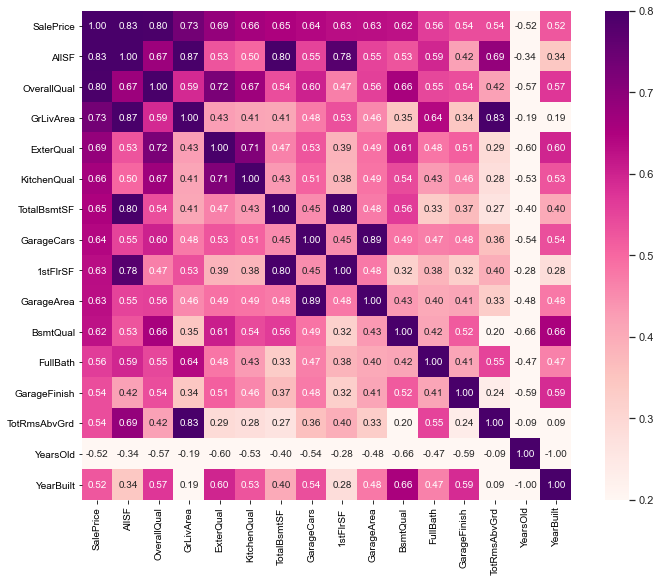

In [30]:
# checkCorr(trainDF, k=11)

pre_df = trainDF.copy()
preprocessAllColumns(pre_df, trainDF)
checkCorr(pre_df, k=16)

# std_df = standardize(pre_df, pre_df)
# checkCorr(std_df, k=11)

In [ ]:
def pairplots(df):
    sns.set()
    sns.pairplot(df, height = 2.5)
    plt.show()

In [ ]:
cols = ["SalePrice", "OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "GarageCars", "BsmtQual", "1stFlrSF", "FullBath", "GarageFinish", "YearsOld"]
pairplots(pre_df.loc[:, cols])

In [148]:
def checkMissingValues(df):
    # BEGIN: from from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
    # EXPLANATION: Caclulate the number and percentage of missing values and diplay
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.loc[missing_data['Total'] !=0])
    # END: from from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python


In [149]:
checkMissingValues(trainDF)
checkMissingValues(testDF)
checkMissingValues(pre_df)

              Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
GarageCond       81  0.055479
GarageType       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
              Total   Percent
PoolQC         1456  0.997944
MiscFeature    1408  0.965045
Alley          1352  0.926662
Fence          1169  0.801234
FireplaceQu     730  0.500343
LotFrontage     227  0.155586
GarageYrBlt      78  0.053461
GarageQual       78  0.053461
GarageFinish     78  0.053461
GarageCond       78  0.053461
GarageType       76  0.052090
BsmtCond         45  0.030843
BsmtQual  

In [ ]:
def checkNormality(df, col):
    # BEGIN: from from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
    # EXPLANATION: Displays histogram and normal probability plot
    sns.distplot(df[col], fit=norm)
    fig = plt.figure()
    res = stats.probplot(df[col], plot=plt)
    # END: from from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

In [ ]:
def logTransformation(df):
    # BEGIN: from from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
    # EXPLANATION: Log transformation
    df['LogSalePrice'] = np.log(df['SalePrice'])
    df['LogGrLivArea'] = np.log(df['GrLivArea'])
    # END: from from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

In [ ]:
# checkNormality(trainDF, 'SalePrice')
checkNormality(trainDF, 'GrLivArea')

In [ ]:
logTransformation(trainDF)
# checkNormality(trainDF, 'LogSalePrice')
checkNormality(trainDF, 'LogGrLivArea')

In [ ]:
plt.scatter(trainDF['LogGrLivArea'], trainDF['LogSalePrice'])

In [ ]:
def calcCorr(df, col1, col2):
    return df.loc[:, col1].corr(df.loc[:, col2])

In [ ]:
calcCorr(trainDF, 'LogSalePrice', 'LogGrLivArea')

In [21]:
    trainDF.loc[:, 'YearsOld'] = diffFromMax(trainDF, trainDF, 'YearBuilt')
    trainDF.loc[:, 'DecadesOld'] = trainDF.loc[:, 'YearsOld'].map(lambda v: v // 10)
    trainDF.loc[:, ['YearsOld', 'DecadesOld']].head()
    

,YearsOld,DecadesOld
0,7,0
1,34,3
2,9,0
3,95,9
4,10,1


In [166]:
testDF.loc[testDF['GarageCars'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1116,2577,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


<AxesSubplot:>

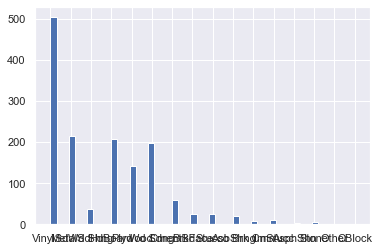

In [177]:
trainDF.loc[:, 'Exterior2nd'].hist(bins=50)

In [176]:
testDF_copy = testDF.copy()
trainDF = pd.read_csv(train_file)
preprocessAllColumns(testDF_copy, trainDF)
print(testDF_copy.loc[:, 'KitchenQual'].map(np.isreal).all())
checkMissingValues(testDF_copy)

True
             Total   Percent
GarageType      76  0.052090
MasVnrType      16  0.010966
Exterior2nd      1  0.000685
BsmtUnfSF        1  0.000685
SaleType         1  0.000685
